In [1]:
from fastmri.data.mri_data import fetch_dir
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule, UnetModule
from fastmri.data import transforms, mri_data
import pathlib
import torch
import matplotlib.pyplot as plt
import numpy as np


CHALLENGE = 'singlecoil'
MASK_TYPE = 'random'
center_fractions = [0.08]
accelerations = [4]


mask = create_mask_for_mask_type(
        MASK_TYPE, center_fractions, accelerations
    )

train_transform = UnetDataTransform(CHALLENGE, mask_func=mask, use_seed=False)

dataset = mri_data.SliceDataset(
    root=pathlib.Path(
      './fastmri_data/singlecoil_val'
    ),
    transform=train_transform,
    challenge='singlecoil'
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=10)
image, target, _, _, _, _, _ = next(iter(dataloader))

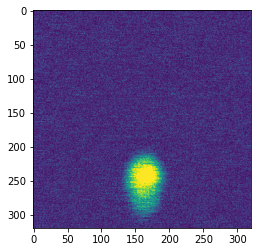

In [2]:
plt.imshow(image.view(-1,320, 320).numpy()[0])

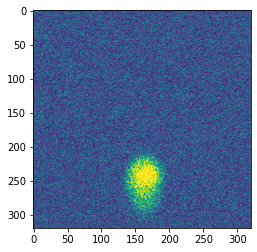

In [3]:
plt.imshow(target.view(-1,320, 320).numpy()[0])

In [4]:

import InvertCnnConverter
import torch
import Unet

In [5]:
import importlib
importlib.reload(InvertCnnConverter)

<module 'InvertCnnConverter' from '/home/hsyang/workspace/20210411_SYS/memcnn-unet/InvertCnnConverter.py'>

In [6]:
plain_model = Unet.UNet(n_channels=1, n_classes=1)

In [7]:
plain_model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [8]:
InvertCnnConverter.convert_module(plain_model, last_module_name='outc', inplace=True)
invert_model = plain_model

device = 'cuda:0'

invert_model = invert_model.to(device)
data = image.view(-1,1,320,320).to(device)
target = target.to(device)

print(invert_model)

UNet(
  (inc): CheckpointModule(
    (module): DoubleConv(
      (double_conv): Sequential(
        (0): RestoreClass(StitchableConv2d(in_channel=1, out_channel=64, kernel=3, stride=1, padding=1, fetch_shape=[128, 128])
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): RestoreClass(StitchableConv2d(in_channel=64, out_channel=64, kernel=3, stride=1, padding=1, fetch_shape=[128, 128])
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
  )
  (down1): CheckpointModule(
    (module): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): UpInvertibleBlock(
              (upscale): Upsample(scale_factor=(2.0, 1.0), mode=bilinear)
              (conv2): InvertibleModuleWrapper(
                

In [10]:


criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(invert_model.parameters(), lr=1e-3)
with torch.autograd.set_detect_anomaly(True) : 
    for epoch in range(10) : 
        result = invert_model(data)
        loss = criterion(result, target)
        optim.zero_grad()
        loss.backward()
        optim.step()
        print(epoch, loss.item())

0 3.6188716888427734
1 3.5172600746154785
2 3.4175913333892822
3 3.3198819160461426
4 3.2244620323181152
5 3.132659673690796
6 3.051062822341919
7 2.985203504562378
8 2.9193246364593506
9 2.8509819507598877
